Method with the highest accuracy and lowest number of features for PR:
{'CSV File': '../../../Data_ML/4_out_csvs_classification\\output_mode_imputed.csv', 'Model': 'KNeighborsClassifier', 'Selection Method': 'SelectKBest_f_classif', 'Number of Features': 20, 'Accuracy': 0.9523809523809523, 'Selected Features': ['Provincial_Class', 'Moss_Cover', 'OF26', 'F1', 'F3_c', 'F3_d', 'F3_e', 'F14', 'F22', 'F23', 'F24', 'F28', 'F29', 'F30', 'F41', 'F43', 'F44', 'F45', 'F46', 'F47']}
Method with the highest accuracy proportionate to the number of features for PR:
{'CSV File': '../../../Data_ML/4_out_csvs_classification\\output_mode_imputed.csv', 'Model': 'KNeighborsClassifier', 'Selection Method': 'SelectKBest_f_classif', 'Number of Features': 2, 'Accuracy': 0.8571428571428571, 'Selected Features': ['F43', 'F45']}
Method with the highest accuracy and lowest number of features for NR:
{'CSV File': '../../../Data_ML/4_out_csvs_classification\\output_mode_imputed.csv', 'Model': 'AdaBoostClassifier', 

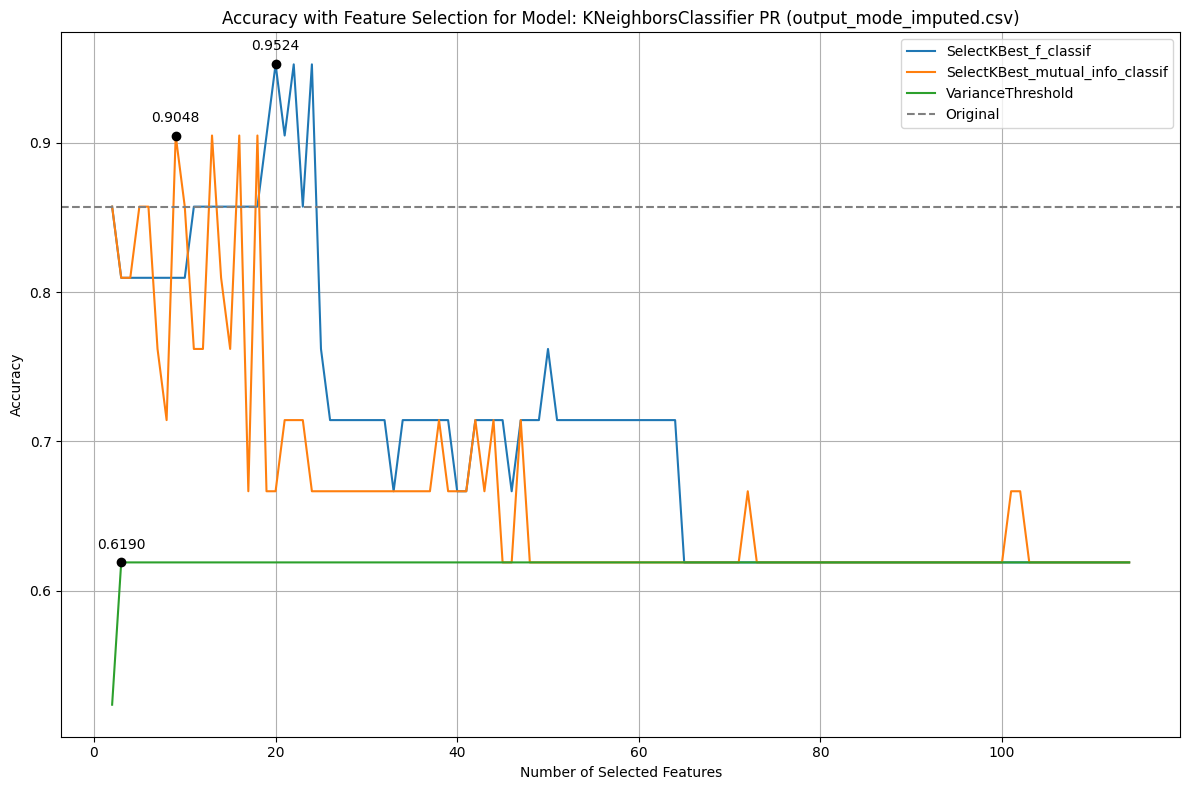

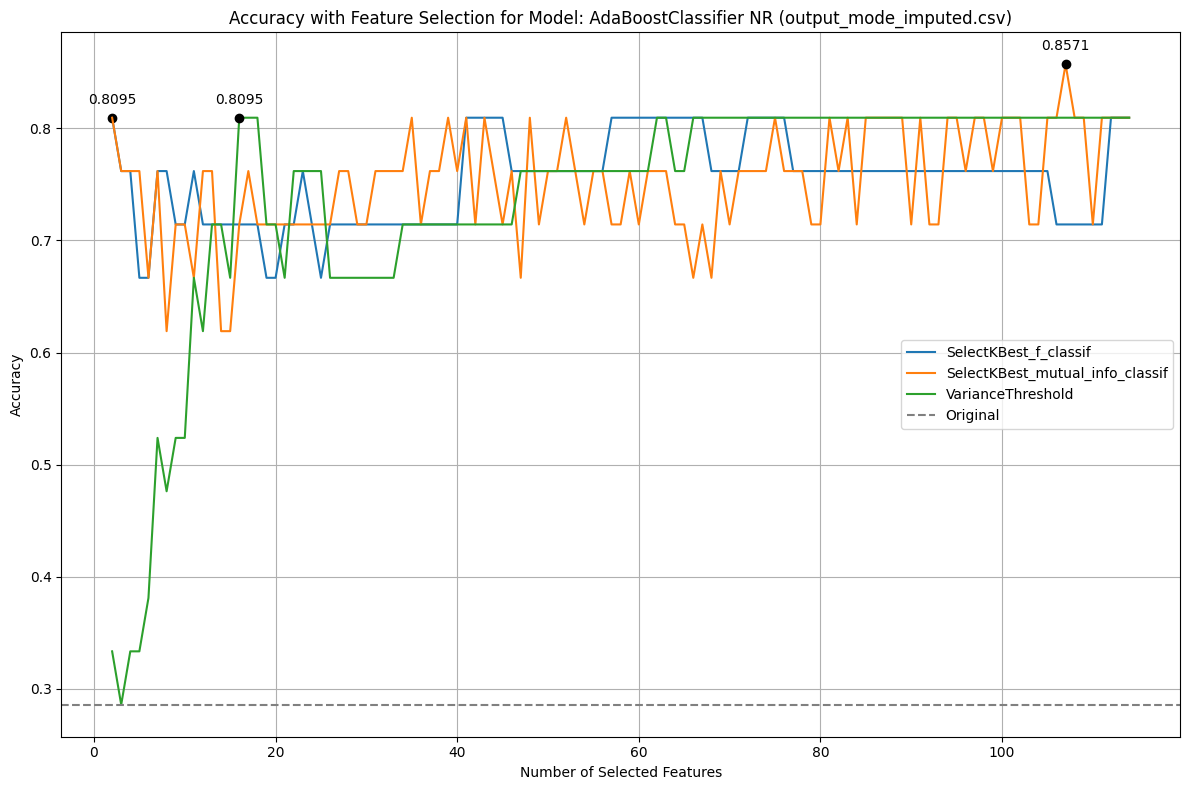

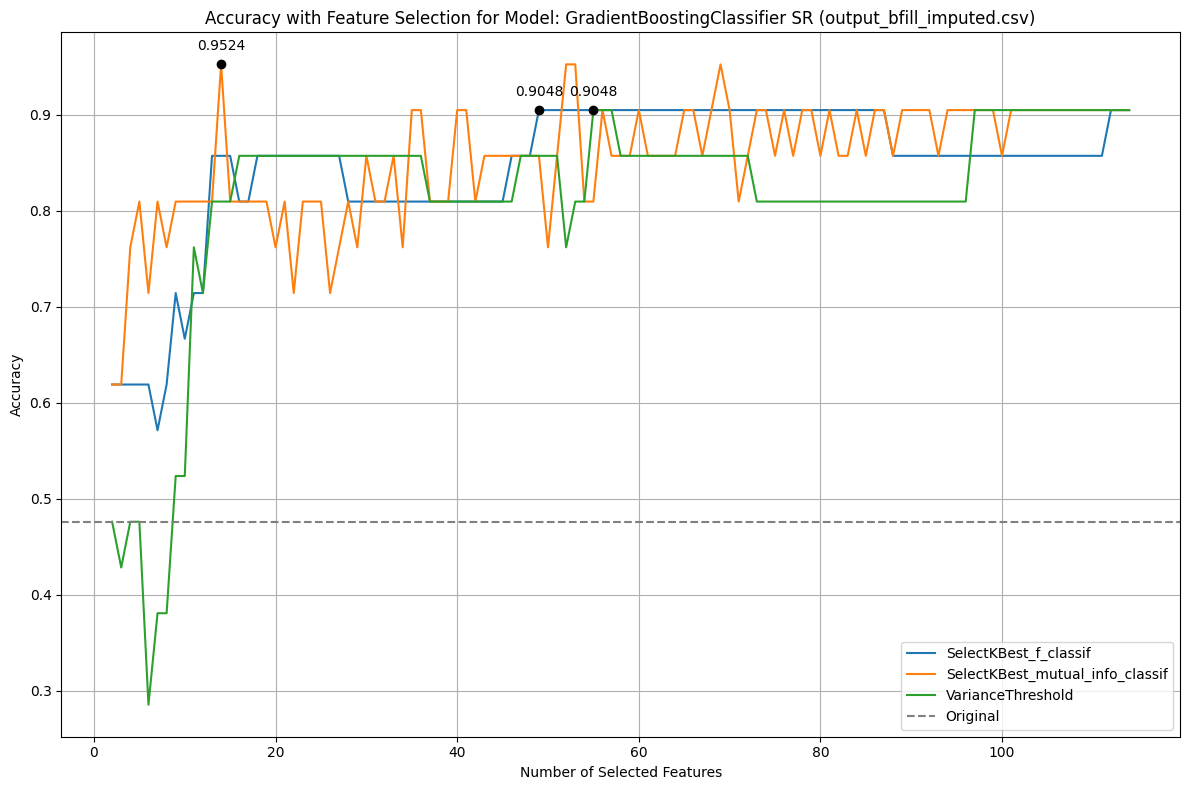

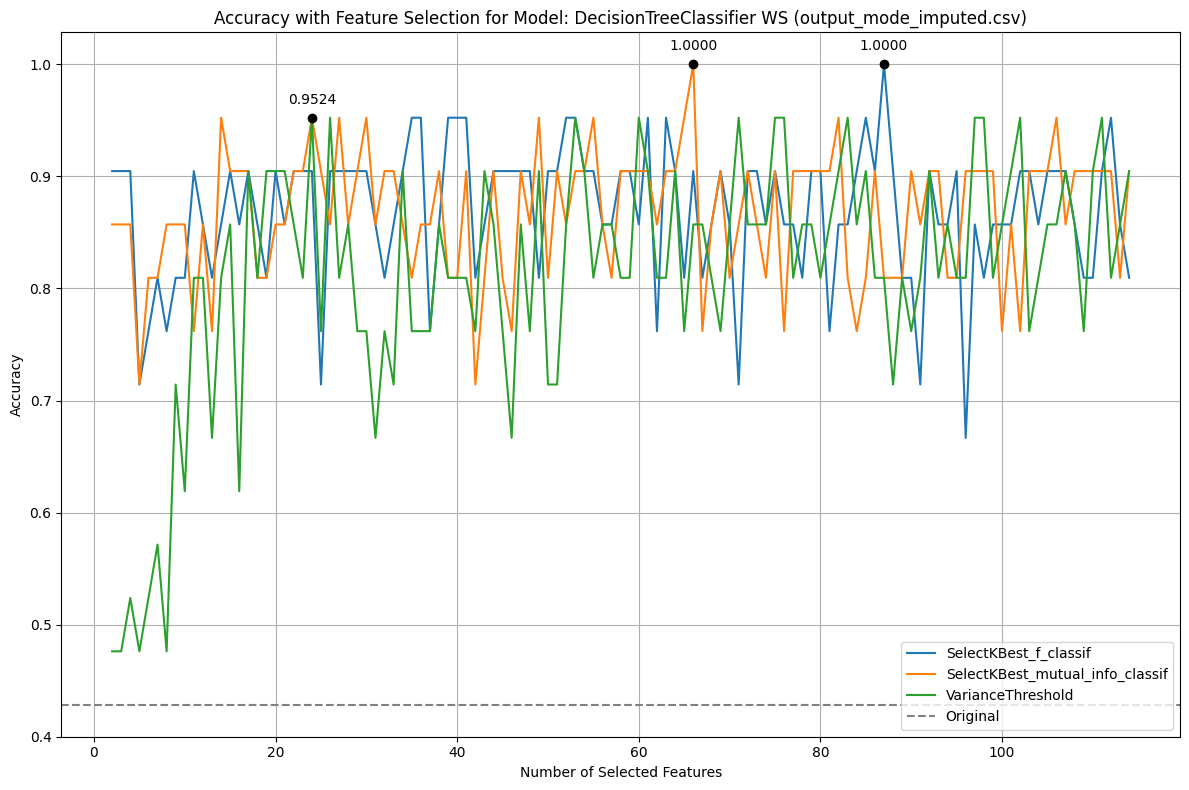

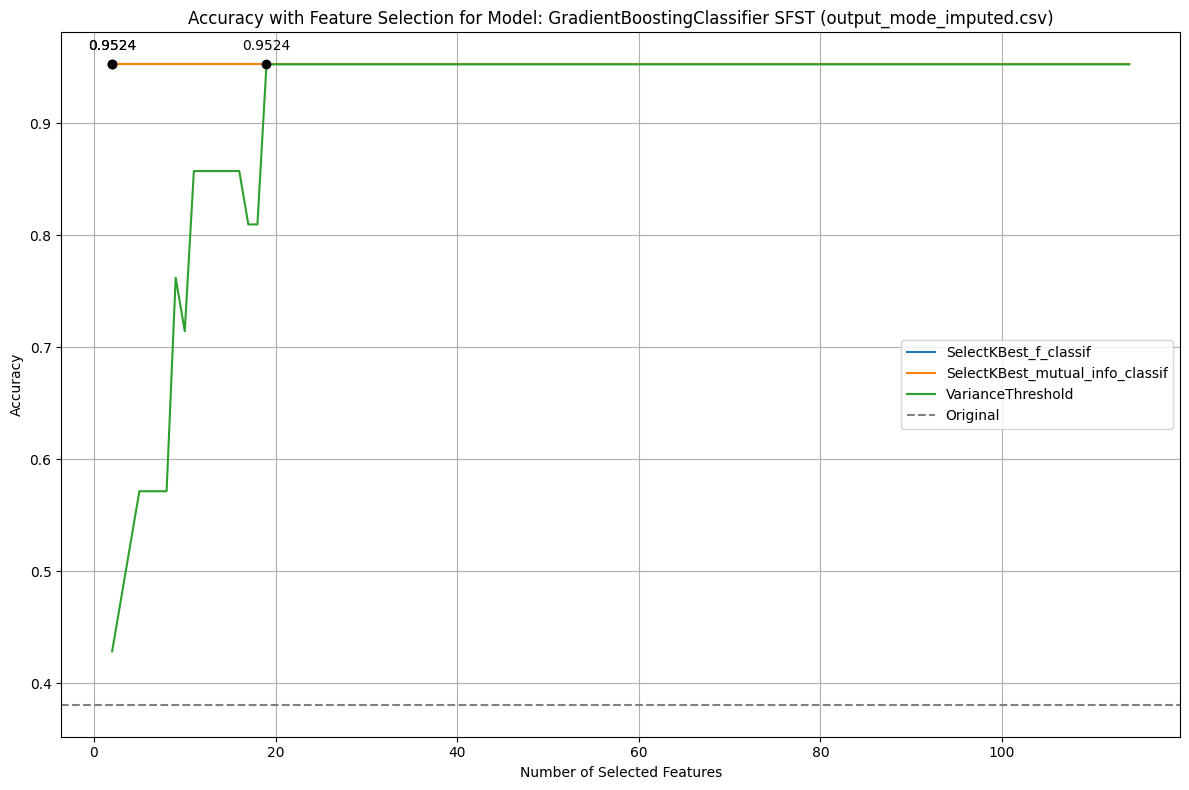

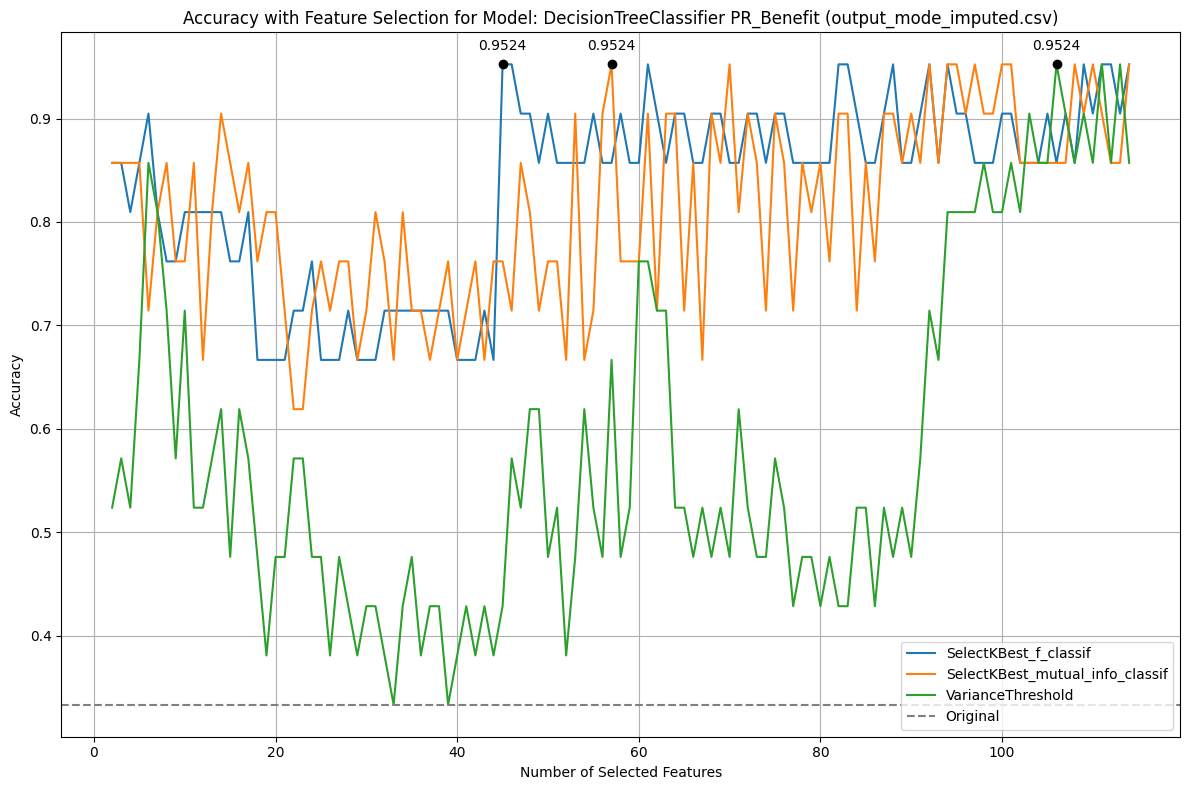

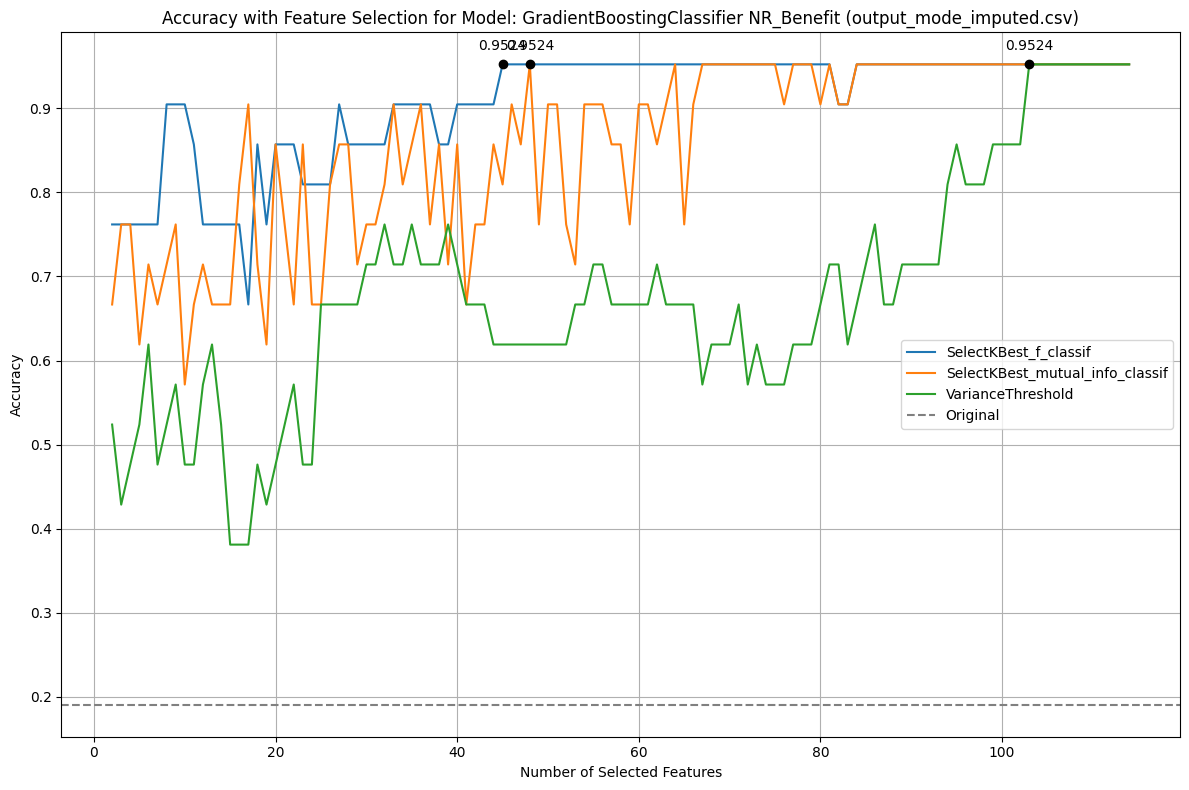

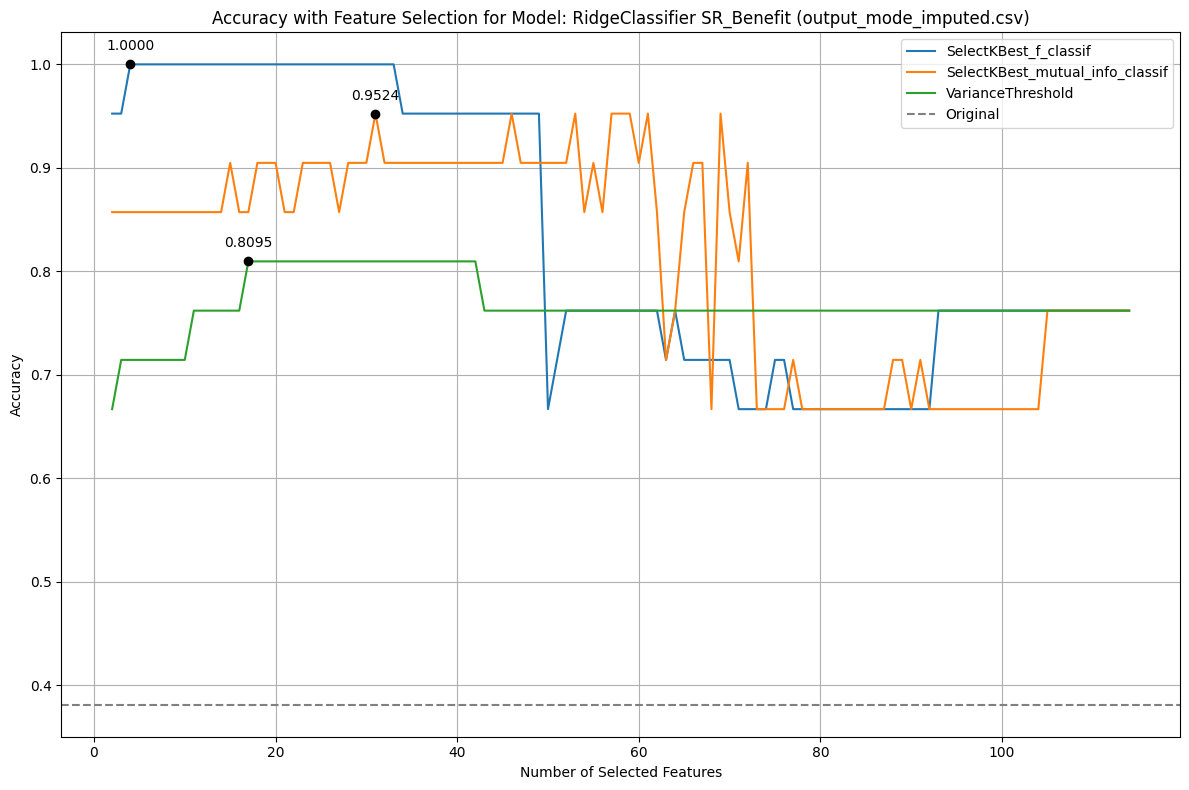

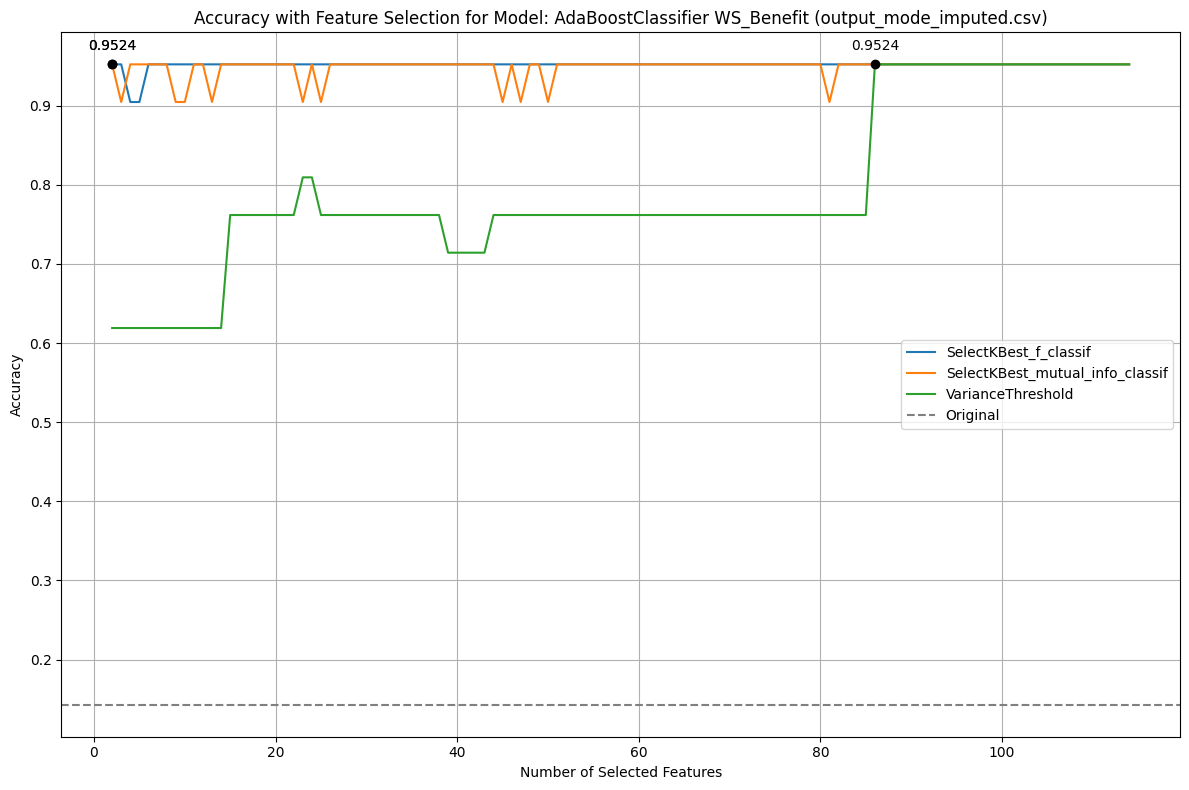

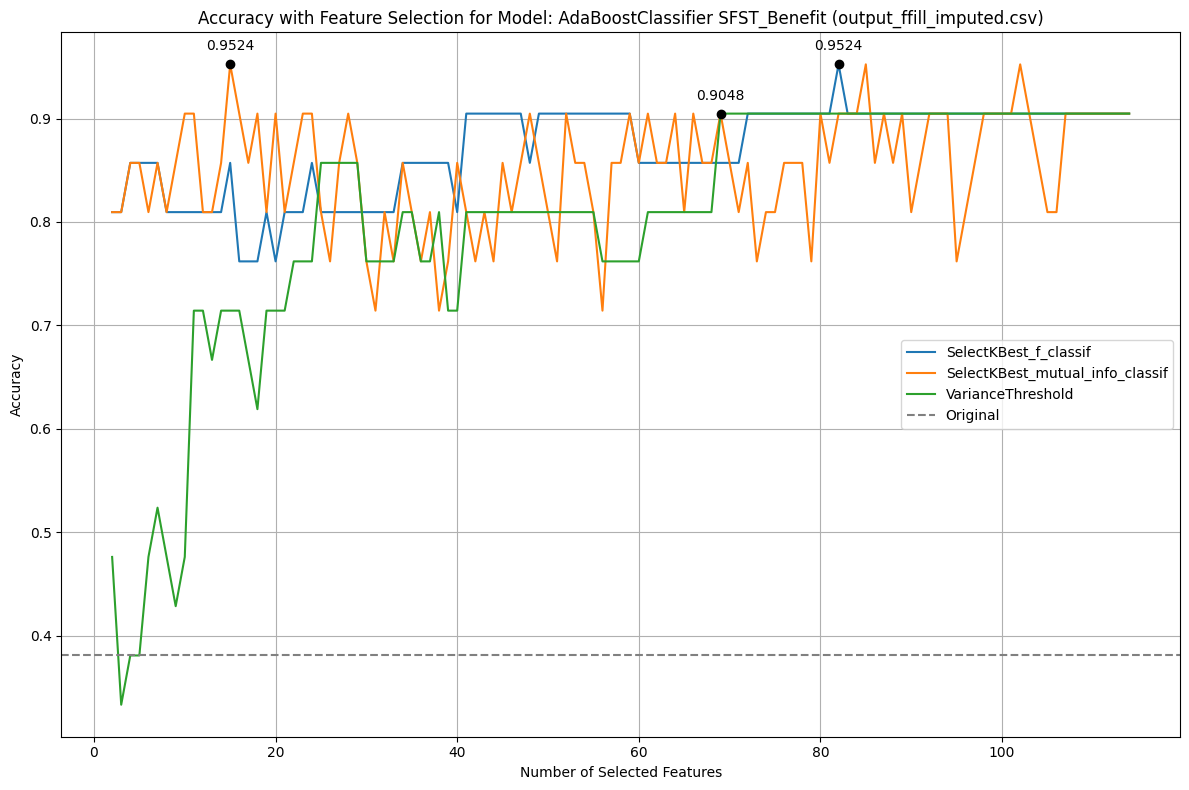

In [5]:
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Define the data columns
data_columns = ['Provincial_Class','Federal_Class','Regime','Vegetation_Type','Vegetation_Cover','Woody_Canopy_Cover','Moss_Cover','Phragmites','Soil_Type','Surface_Water_Present','Saturation_Depth','Living_Moss_Depth','Organic_Depth','Hydrogeomorphic_Class',
    'OF2', 'OF3', 'OF4', 'OF5', 'OF6', 'OF7', 'OF8', 'OF9', 'OF10', 'OF11', 'OF13', 'OF14', 'OF15', 'OF16', 'OF17',
    'OF18', 'OF19', 'OF20', 'OF21', 'OF22', 'OF23', 'OF24', 'OF25', 'OF26', 'OF27', 'OF28',  'OF31',
    'OF33', 'OF34', 'OF37', 'OF38', 'F1', 'F2', 'F3_a', 'F3_b', 'F3_c', 'F3_d', 'F3_e', 'F3_f', 'F3_g', 'F4', 'F5', 'F6',
    'F7', 'F8', 'F9', 'F10',  'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23',
    'F24', 'F25',  'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40',
    'F41',  'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'F49', 'F50', 'F51', 'F52', 'F53', 'F54', 'F55', 'F56', 'F57',
    'F58', 'F59', 'F62', 'F63', 'F64', 'F67', 'F68', 'S1', 'S2', 'S4', 'S5'
]


from sklearn.feature_selection import SelectPercentile, chi2

feature_selection_techniques = {
    "SelectKBest_f_classif": SelectKBest(score_func=f_classif),
    "SelectKBest_mutual_info_classif": SelectKBest(score_func=mutual_info_classif),
    "VarianceThreshold": VarianceThreshold(threshold=0.1),  # Example threshold, adjust as needed
}

# Define a mapping from model names to model classes
model_mapping = {
    'RidgeClassifier': RidgeClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'AdaBoostClassifier': AdaBoostClassifier,
    'KNeighborsClassifier': KNeighborsClassifier,
    'MLPClassifier': MLPClassifier,
    'LogisticRegression': LogisticRegression,
    'SGDClassifier': SGDClassifier,
    'SVC': SVC,
    'Perceptron': Perceptron,
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier
}

# Function to load, evaluate, and retrain the best model with feature selection
def load_evaluate_and_retrain_best_model_with_feature_selection(csv_file, model_name, model_path, hyperparameters, results_column):
    # Load data from CSV
    data = pd.read_csv(csv_file)
    X = data[data_columns]
    y = data[results_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Load the original model and calculate accuracy
    if model_name == 'TensorFlow':
        model = tf.keras.models.load_model(model_path)
        y_pred = model.predict(X_test_scaled)
        y_pred_classes = np.argmax(y_pred, axis=1)
    else:
        model = joblib.load(model_path)
        y_pred_classes = model.predict(X_test_scaled)

    accuracy_original = accuracy_score(y_test, y_pred_classes)
    selection_results = {'Original': accuracy_original}
    feature_selection_data = []  # To store feature selection results
    test_results = []  # To store test results (actual and predicted)

    # Iterate over each feature selection technique
    for name, selector in feature_selection_techniques.items():
        accuracy_values = []

        for k in range(2, len(data_columns) + 1):  # Iterate over all possible numbers of features
            if isinstance(selector, SelectKBest):
                selector.set_params(k=k)
                X_train_selected = selector.fit_transform(X_train, y_train)
                X_test_selected = selector.transform(X_test)
            elif isinstance(selector, VarianceThreshold):
                selector.set_params(threshold=0.00)
                X_train_selected = selector.fit_transform(X_train, y_train)
                X_test_selected = selector.transform(X_test)

                # Sort the features by variance, select top k
                selected_indices = np.argsort(-selector.variances_)[:k]
                X_train_selected = X_train_selected[:, selected_indices]
                X_test_selected = X_test_selected[:, selected_indices]
            else:
                continue

            # Retrain the model with the selected features
            if model_name == 'TensorFlow':
                # Model setup and training for TensorFlow
                model = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape=(X_train_selected.shape[1],)),
                    tf.keras.layers.Dense(hyperparameters['units'], activation=hyperparameters['activation']),
                    tf.keras.layers.Dense(3, activation='softmax')
                ])
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate']),
                              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train_selected, y_train, epochs=hyperparameters['epochs'], verbose=0)
                y_pred = model.predict(X_test_selected)
                y_pred_classes = np.argmax(y_pred, axis=1)
            else:
                # Model setup and training for other models
                model_class = model_mapping.get(model_name)
                if not model_class:
                    print(f"Unknown model name: {model_name}")
                    continue
               
                model_hyperparameters = {k.split('__', 1)[1]: v for k, v in hyperparameters.items() if
                                         k.startswith(model_name.lower())}
                model = model_class(**model_hyperparameters)
                model.fit(X_train_selected, y_train)
                y_pred_classes = model.predict(X_test_selected)

            # Calculate accuracy and store the results
            accuracy = accuracy_score(y_test, y_pred_classes)
            accuracy_values.append(accuracy)

            # Store feature selection results
            if isinstance(selector, SelectKBest):
                selected_features = selector.get_support(indices=True)
            elif isinstance(selector, VarianceThreshold):
                selected_features = selected_indices  # Use the sorted indices for top k features

            feature_selection_data.append({
                'CSV File': csv_file,
                'Model': model_name,
                'Selection Method': name,
                'Number of Features': k,
                'Accuracy': accuracy,
                'Selected Features': [data_columns[i] for i in selected_features]
            })

            # Store test results
            test_results.append({
                'CSV File': csv_file,
                'Model': model_name,
                'Selection Method': name,
                'Number of Features': k,
                'Actual': ','.join(map(str, y_test.values)),
                'Predicted': ','.join(map(str, y_pred_classes)),
                'Accuracy': accuracy,
                'Selected Features': [data_columns[i] for i in selected_features]
            })

        selection_results[name] = accuracy_values

    return selection_results, feature_selection_data, test_results

# Loop through result columns
result_columns_list = ['PR', 'NR', 'SR', 'WS', 'SFST','PR_Benefit', 'NR_Benefit', 'SR_Benefit', 'WS_Benefit', 'SFST_Benefit']

for result_column in result_columns_list:
    best_models_df = pd.read_csv(f"../TrainingResults/best_models_info{result_column}.csv")
    model_directory = f"../TrainingResults/csvs/{result_column}"

    # Find the best model from best_models_df
    best_model = best_models_df.loc[best_models_df['accuracy'].idxmax()]

    # Load data for the best model
    csv_file = os.path.join('../../../Data_ML/4_out_csvs_classification', best_model['csv_file'])
    model_name = best_model['model_name']
    model_path = os.path.join(model_directory,
                              f"{best_model['csv_file']}_{model_name}_model.pkl" if model_name != 'TensorFlow' else f"{best_model['csv_file']}_TensorFlow_model.h5")
    hyperparameters = ast.literal_eval(best_model['hyperparameters'])

    # Perform feature selection and retraining for the best model
    reduction_results, feature_selection_data, test_results = load_evaluate_and_retrain_best_model_with_feature_selection(csv_file, model_name, model_path, hyperparameters, result_column)

    # Define X and y using the loaded data
    data = pd.read_csv(csv_file)
    X = data[data_columns]
    y = data[result_column]

    # Plot accuracy values for each reduction method for the current CSV file
    plt.figure(figsize=(12, 8))
    
    for name, accuracy_values in reduction_results.items():
        if name != 'Original':  # Skip 'Original' since it doesn't have varying components
            plt.plot(range(2, len(accuracy_values) + 2), accuracy_values, label=name)
    
            # Find the index of the maximum accuracy value
            max_index = np.argmax(accuracy_values)
            max_accuracy = accuracy_values[max_index]
            # Plot the black dot for the maximum accuracy value
            plt.plot(max_index + 2, max_accuracy, 'ko')  # 'ko' is for black dot
            # Annotate the maximum accuracy value
            plt.annotate(f'{max_accuracy:.4f}', (max_index + 2, max_accuracy),
                         textcoords="offset points", xytext=(0, 10), ha='center')
    
    # Add original accuracy to the plot
    plt.axhline(y=reduction_results['Original'], color='gray', linestyle='--', label='Original')
    
    # Add labels and legend
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy with Feature Selection for Model: {model_name} {result_column} ({best_model["csv_file"]})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"feature_selection_accuracy_plot_{best_model['csv_file']}_{model_name}_{result_column}.png")
    
    # Show plot
    #plt.show()

    # Save test results to a CSV file
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv(f"test_results_{result_column}.csv", index=False)

    # Find the method with the highest accuracy and lowest number of features
    best_method = min(feature_selection_data, key=lambda x: (-x['Accuracy'], x['Number of Features']))
    print(f"Method with the highest accuracy and lowest number of features for {result_column}:")
    print(best_method)

    # Find the method with the highest accuracy proportionate to the number of features
    best_method_proportionate = max(feature_selection_data, key=lambda x: (x['Accuracy'] / x['Number of Features']))
    print(f"Method with the highest accuracy proportionate to the number of features for {result_column}:")
    print(best_method_proportionate)
